In [2]:
import pandas as pd
import numpy as np
import re
import time
import nltk
import spacy
import matplotlib.pyplot as plt
from spacy.lang.nl.examples import sentences
from tqdm import tqdm

### Whisper transcripties genereren

In [ ]:
!pip install git+https://github.com/openai/whisper.git 

In [ ]:
output = !whisper "aflevering112Vandaag.mp4" --model small --language English

In [ ]:
lines = output.split("\n")
text = "\n".join(line.split("] ")[-1] for line in lines)

with open("aflevering112Vandaag_analyse.txt", "w") as file:
    file.write(text)

## Preprocessing
Eerst moeten de transcripties van de aflevering handmatig gecontroleerd en gecorrigeerd worden (ground truth spraak/referentie). Vervolgens moet bij elke transcriptie aangegeven worden welke spreker sprak (spreker_id). Dit nieuwe bestand is invoer voor onderstaande code.

### DataFrame maken van de Whisper output

In [3]:
def read_text_file(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        data = file.readlines()
    # Optioneel: Verwijder de nieuwe regelkarakters ('\n') aan het einde van elke regel
    data = [line.rstrip('\n') for line in data]
    return data

filename = 'aflevering112Vandaag_analyse.txt'
data = read_text_file(filename)
print(data)

['[\'Elke dag wordt de land nummer 1 en 2 duizenden keren gebeld.\', \'Hier zie je de belangrijkste meldingen van woensdag 1 september.\', \'Scooter Brand slaat over op woning in Noordwijk, buren reageren alert.\', \'Inbreker op, heet er daad betrapt, in het Brabantse vrucht.\', \'Zijn compagnon is nog voortvluchtig.\', \'Arrestatieteam doet inval bij een woning in Alblasserdam.\', \'En Ellie lust over hoe het komt dat een lijkwagen in Den Haag...\', \'verzeild raakt in een kettingbotsing.\', \'Dit is 1 en 2 vandaag.\', \'Alarmcentraal 1 en 2 wil de politiebrood in Van Kroos.\', \'Goedenavond.\', \'De politie is iets na half acht massaal uitgerukt...\', \'voor een ruzie in het centrum van Bunschoten, in de provincie Utrecht.\', \'De politie kreeg een melding binnen van een ruzie op straat...\', \'waarbij gedreigd zou zijn met een vuurwapen.\', \'Meerdere agenten met kogen weer in de vesten...\', \'en een politiehelicopter werden ingezet.\', \'Voor ons nog is niet duidelijk wat er preci

In [4]:
data_cleaned = data[0].strip('[]').replace('\ ', '')
transcripties = re.split(r"', '|',|, '", data_cleaned)

transcripties = [transcriptie.strip() for transcriptie in transcripties]
df = pd.DataFrame(transcripties, columns=['Regel'])

print(df)

                                                 Regel
0    'Elke dag wordt de land nummer 1 en 2 duizende...
1    Hier zie je de belangrijkste meldingen van woe...
2    Scooter Brand slaat over op woning in Noordwij...
3    Inbreker op, heet er daad betrapt, in het Brab...
4                 Zijn compagnon is nog voortvluchtig.
..                                                 ...
397                                 Eindsgoed al goed.
398                       Zo, tot zover 1-1-2 vandaag.
399                          Nog een hele fijne avond.
400       En je weet het, alleen bij Spoot, bel 1-1-2.
401                               TV Gelderland 2021.'

[402 rows x 1 columns]


In [5]:
df.to_csv('112Vandaag_aflevering1_totaal.csv', index=False)

### Lijst maken met de zinnen/transcripties uit aflevering

In [6]:
transcripties = pd.read_excel('112Vandaag_aflevering1_totaal.xlsx')
transcripties = pd.DataFrame(transcripties)

In [7]:
transcripties_truth = transcripties['truth'].tolist()
transcripties_whisper = transcripties['whisper'].tolist()

### Verkeerd voorspelde woorden lijst maken en POS-tags geven

In [8]:
!python -m spacy download nl_core_news_md
nlp = spacy.load("nl_core_news_md")

     ---------------------------------------- 42.8/42.8 MB 9.3 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('nl_core_news_md')


In [9]:
import warnings

def ignore_warnings():
    warnings.filterwarnings("ignore")
ignore_warnings()

df = pd.DataFrame(columns=['Verkeerd woord', 'POS-tag'])

for i in tqdm(range(len(transcripties['truth']))):
    goed = transcripties_truth[i]
    doc_goed = nlp(goed)

    whisper = transcripties_whisper[i]
    doc = nlp(whisper)

    doc_list = str(doc).split()
    doc_goed_list = str(doc_goed).split()

    tags = [token.pos_ for token in doc]
    tags_goed = [token.pos_ for token in doc_goed]
    
    verkeerd_voorspeld = []
    for woord in doc_goed_list:
        if woord not in doc_list:
            verkeerd_voorspeld.append(woord)

    woorden = []
    tags = []

    for token_goed in doc_goed:
        if token_goed.tag_.split('|')[0] != '_SP':
            if len(token_goed.text)>2:
                woord = token_goed.text
                tag = token_goed.tag_.split('|')[0]
                woorden.append(woord)
                tags.append(tag)

    ground_truth_pos_tags = list(zip(woorden, tags))

    verkeerd_voorspeld = []
    for woord, tag in ground_truth_pos_tags:
        if woord not in doc_list:
            verkeerd_voorspeld.append((woord, tag))
                
    for woord, tag in verkeerd_voorspeld:
        df = df.append({'Verkeerd woord': woord, 'POS-tag': tag}, ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████| 401/401 [00:21<00:00, 18.27it/s]


In [8]:
df.head(10)

,Verkeerd woord,POS-tag
0,alarmnummer,N
1,1-1-2,TW
2,gebeld,WW
3,september,N
4,Scooterbrand,N
5,Noordwijk,N
6,alert,ADJ
7,betrapt,WW
8,Vucht,N
9,voortvluchtig,ADJ


In [10]:
df.to_csv('112Vandaag_aflevering1_verkeerdewoorden.csv', index=False)

#### Alle woorden lijst maken

In [12]:
ignore_warnings()

df_alles = pd.DataFrame(columns=['Woord', 'POS-tag'])

for i in tqdm(range(len(transcripties['truth']))):
    goed = transcripties_truth[i]
    doc_goed = nlp(goed)

    doc_goed_list = str(doc_goed).split()

    tags_goed = [token.pos_ for token in doc_goed]
    
    alle_woorden = []
    for woord in doc_goed_list:
        alle_woorden.append(woord)

    woorden = []
    tags = []

    for token_goed in doc_goed:
        if token_goed.tag_.split('|')[0] != '_SP':
            if len(token_goed.text)>2:
                woord = token_goed.text
                tag = token_goed.tag_.split('|')[0]
                woorden.append(woord)
                tags.append(tag)

    ground_truth_pos_tags = list(zip(woorden, tags))

    alle_woorden = []
    for woord, tag in ground_truth_pos_tags:
        alle_woorden.append((woord, tag))
                
    for woord, tag in alle_woorden:
        df_alles = df_alles.append({'Woord': woord, 'POS-tag': tag}, ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████| 401/401 [00:22<00:00, 17.61it/s]


In [113]:
df_alles.head()

,Woord,POS-tag
0,Elke,VNW
1,dag,N
2,wordt,WW
3,alarmnummer,N
4,1-1-2,TW


In [114]:
df_alles.to_csv('112Vandaag_aflevering1_allewoorden.csv', index=False)

### Koppelen verkeerd voorspelde woorden aan personen en bijbehorende gegevens

In [122]:
woorden = pd.read_csv('112Vandaag_aflevering1_verkeerdewoorden.csv')
woorden = pd.DataFrame(woorden)

In [123]:
woorden['Transcriptie-index'] = None

huidige_transcriptie_index = 0

for index, row in woorden.iterrows():
    verkeerd_voorspeld_woord = row['Verkeerd woord']
    
    transcriptie_index = None
    for i in range(huidige_transcriptie_index, len(transcripties_truth)):
        transcriptie = transcripties_truth[i]
        if verkeerd_voorspeld_woord in transcriptie:
            transcriptie_index = i
            break
    
    woorden.at[index, 'Transcriptie-index'] = transcriptie_index
    
    if transcriptie_index is not None:
        huidige_transcriptie_index = transcriptie_index

print(woorden)

    Verkeerd woord POS-tag Transcriptie-index
0      alarmnummer       N                  0
1            1-1-2      TW                  0
2           gebeld      WW                  0
3        september       N                  1
4     Scooterbrand       N                  2
..             ...     ...                ...
778     112Vandaag      TW                398
779          avond       N                399
780            het     VNW                400
781          spoed       N                400
782          1-1-2      TW                400

[783 rows x 3 columns]


In [124]:
gegevens = pd.read_excel('112aflevering1gegevens.xlsx')
gegevens = pd.DataFrame(gegevens)

woorden['geslacht'] = None
woorden['leeftijd'] = None
woorden['dialectregio'] = None
woorden['studio'] = None

In [125]:
woorden = woorden.merge(transcripties['spreker_id'].reset_index(), left_on='Transcriptie-index', right_index=True)
woorden = woorden.merge(gegevens, on='spreker_id', how='left')

In [126]:
woorden = woorden.drop(['geslacht_x', 'leeftijd', 'dialectregio_x','studio_x','index'], axis=1)

In [90]:
woorden.head()

,Verkeerd woord,POS-tag,Transcriptie-index,index,spreker_id,geslacht_y,leeftijdscategorie,dialectregio_y,studio_y
0,alarmnummer,N,0,0,1.0,F,2.0,2.0,ja
1,1-1-2,TW,0,0,1.0,F,2.0,2.0,ja
2,gebeld,WW,0,0,1.0,F,2.0,2.0,ja
3,september,N,1,1,1.0,F,2.0,2.0,ja
4,Scooterbrand,N,2,2,1.0,F,2.0,2.0,ja


## Morfologische analyses

In [225]:
word_counts = woorden['Verkeerd woord'].value_counts()

sorted_words = word_counts.sort_values(ascending=False)
top_n = 21
print(sorted_words.head(top_n))

...             28
doen            12
Nou             12
1-1-2           10
van              9
één              9
goed             8
zijn             7
aan              6
hebben           6
brandblusser     5
blussen          5
gebeuren         5
auto             5
worden           5
aangehouden      4
het              4
ingebroken       4
politie          4
zeker            4
brandweer        4
Name: Verkeerd woord, dtype: int64


In [227]:
from collections import Counter

fouten = woorden['Verkeerd woord'].tolist()
fouten_frequentie = Counter(fouten).most_common()

for fout, frequentie in fouten_frequentie[:20]:
    print(f"Fout: {fout} - Frequentie: {frequentie}")

foutpatronen = set()
for fout in fouten:
    foutpatroon = fout[0]
    foutpatronen.add(foutpatroon)

print("Unieke foutpatronen:")
for patroon in foutpatronen:
    print(patroon)


Fout: ... - Frequentie: 28
Fout: doen - Frequentie: 12
Fout: Nou - Frequentie: 12
Fout: 1-1-2 - Frequentie: 10
Fout: van - Frequentie: 9
Fout: één - Frequentie: 9
Fout: goed - Frequentie: 8
Fout: zijn - Frequentie: 7
Fout: aan - Frequentie: 6
Fout: hebben - Frequentie: 6
Fout: blussen - Frequentie: 5
Fout: brandblusser - Frequentie: 5
Fout: auto - Frequentie: 5
Fout: gebeuren - Frequentie: 5
Fout: worden - Frequentie: 5
Fout: politie - Frequentie: 4
Fout: brandweer - Frequentie: 4
Fout: aangehouden - Frequentie: 4
Fout: het - Frequentie: 4
Fout: ingebroken - Frequentie: 4
Unieke foutpatronen:
g
W
z
e
H
F
v
u
J
G
.
h
n
I
N
B
m
V
M
P
K
T
U
é
k
O
l
d
a
b
f
p
t
r
S
R
A
c
o
s
E
i
1
Z
D
j
w


In [237]:
# Syntactisch
import spacy

nlp = spacy.load('nl_core_news_md')

sentences = list(transcripties['whisper'])

syntactic_patterns = []
for sentence in sentences:
    doc = nlp(sentence)
    patterns = []
    for token in doc:
        if token.pos_ == 'NOUN':
            patterns.append('N')
        elif token.pos_ == 'PUNCT':
            patterns.append('PUNCT')
        elif token.pos_ == 'ADJ':
            patterns.append('ADJ')
        elif token.pos_ == 'ADV':
            patterns.append('ADV')
        elif token.pos_ == 'AUX':
            patterns.append('AUX')
        elif token.pos_ == 'CCONJ':
            patterns.append('CCNOJ')
        elif token.pos_ == 'VERB':
            patterns.append('VERB')
        elif token.pos_ == 'PRON':
            patterns.append('PRON')
        elif token.pos_ == 'DET':
            patterns.append('DET')
        elif token.pos_ == 'ADP':
            patterns.append('ADP')
        elif token.pos_ == 'NUM':
            patterns.append('NUM')
        elif token.pos_ == 'INTJ':
            patterns.append('INTJ')
        elif token.pos_ == 'SCONJ':
            patterns.append('SCONJ')
        elif token.pos_ == 'SYM':
            patterns.append('SYM')
        elif token.pos_ == 'SPACE':
            patterns.append('SPACE')
        # Voeg hier meer syntactische patronen toe op basis van de POS-tags van spacy
        else:
            patterns.append('Other')
    syntactic_patterns.append(patterns)

# Voorbeeld van het tonen van de meest voorkomende syntactische patronen
frequency_distribution = nltk.FreqDist(tuple(patterns) for patterns in syntactic_patterns)
most_common_patterns = frequency_distribution.most_common(10)
print(most_common_patterns)


[(('Other', 'PUNCT'), 3), (('SCONJ', 'PRON', 'ADP', 'ADJ', 'VERB', 'PUNCT', 'VERB', 'PRON', 'ADJ', 'PUNCT'), 2), (('VERB', 'PUNCT'), 2), (('DET', 'N', 'AUX', 'DET', 'N', 'N', 'NUM', 'CCNOJ', 'NUM', 'NUM', 'N', 'VERB', 'PUNCT'), 1), (('ADV', 'VERB', 'PRON', 'DET', 'ADJ', 'N', 'ADP', 'Other', 'NUM', 'Other', 'PUNCT'), 1), (('N', 'Other', 'VERB', 'ADP', 'ADP', 'N', 'ADP', 'Other', 'PUNCT', 'N', 'VERB', 'ADJ', 'PUNCT'), 1), (('Other', 'ADP', 'PUNCT', 'VERB', 'ADV', 'N', 'VERB', 'PUNCT', 'ADP', 'DET', 'ADJ', 'N', 'PUNCT'), 1), (('PRON', 'N', 'AUX', 'ADV', 'ADJ', 'PUNCT'), 1), (('N', 'VERB', 'N', 'ADP', 'DET', 'N', 'ADP', 'Other', 'PUNCT'), 1), (('CCNOJ', 'Other', 'N', 'ADP', 'ADV', 'PRON', 'VERB', 'SCONJ', 'DET', 'N', 'ADP', 'Other', 'Other', 'PUNCT'), 1)]


### Alle woorden gegevens aanvullen

In [115]:
woorden_alles = pd.read_csv('112Vandaag_aflevering1_allewoorden.csv')
woorden_alles = pd.DataFrame(woorden_alles)

In [116]:
woorden_alles['Transcriptie-index'] = None

huidige_transcriptie_index = 0

for index, row in woorden_alles.iterrows():
    elk_woord = row['Woord']
    
    transcriptie_index = None
    for i in range(huidige_transcriptie_index, len(transcripties_truth)):
        transcriptie = transcripties_truth[i]
        if elk_woord in transcriptie:
            transcriptie_index = i
            break
    
    woorden_alles.at[index, 'Transcriptie-index'] = transcriptie_index
    
    if transcriptie_index is not None:
        huidige_transcriptie_index = transcriptie_index

print(woorden_alles)

            Woord POS-tag Transcriptie-index
0            Elke     VNW                  0
1             dag       N                  0
2           wordt      WW                  0
3     alarmnummer       N                  0
4           1-1-2      TW                  0
...           ...     ...                ...
3671       alleen      BW                400
3672          bij      VZ                400
3673        spoed       N                400
3674          bel      WW                400
3675        1-1-2      TW                400

[3676 rows x 3 columns]


In [117]:
gegevens = pd.read_excel('112aflevering1gegevens.xlsx')
gegevens = pd.DataFrame(gegevens)

woorden_alles['geslacht'] = None
woorden_alles['leeftijd'] = None
woorden_alles['dialectregio'] = None
woorden_alles['studio'] = None

In [118]:
woorden_alles = woorden_alles.merge(transcripties['spreker_id'].reset_index(), left_on='Transcriptie-index', right_index=True)
woorden_alles = woorden_alles.merge(gegevens, on='spreker_id', how='left')

In [119]:
woorden_alles = woorden_alles.drop(['geslacht_x', 'leeftijd', 'dialectregio_x','studio_x','index'], axis=1)

In [120]:
woorden_alles.head()

,Woord,POS-tag,Transcriptie-index,spreker_id,geslacht_y,leeftijdscategorie,dialectregio_y,studio_y
0,Elke,VNW,0,1.0,F,2.0,2.0,ja
1,dag,N,0,1.0,F,2.0,2.0,ja
2,wordt,WW,0,1.0,F,2.0,2.0,ja
3,alarmnummer,N,0,1.0,F,2.0,2.0,ja
4,1-1-2,TW,0,1.0,F,2.0,2.0,ja


### Analyses

#### Hoeveel verkeerd voorspelde woorden per regio per woordsoort

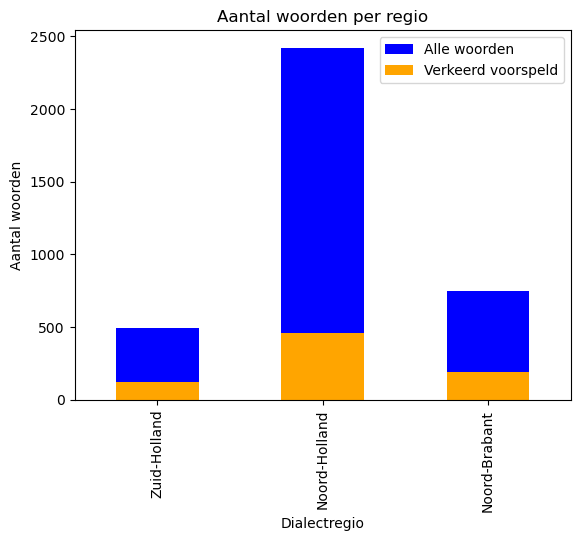

In [140]:
fig, ax = plt.subplots()

grouped_alles_sum.plot(kind='bar', ax=ax, label='Alle woorden', color='blue')

grouped_sum.plot(kind='bar', ax=ax, label='Verkeerd voorspeld', color='orange')

plt.xlabel('Dialectregio')
plt.ylabel('Aantal woorden')
plt.title('Aantal woorden per regio')
plt.xticks(range(len(grouped_sum.index)), ['Zuid-Holland', 'Noord-Holland', 'Noord-Brabant'])
plt.legend()
plt.show()



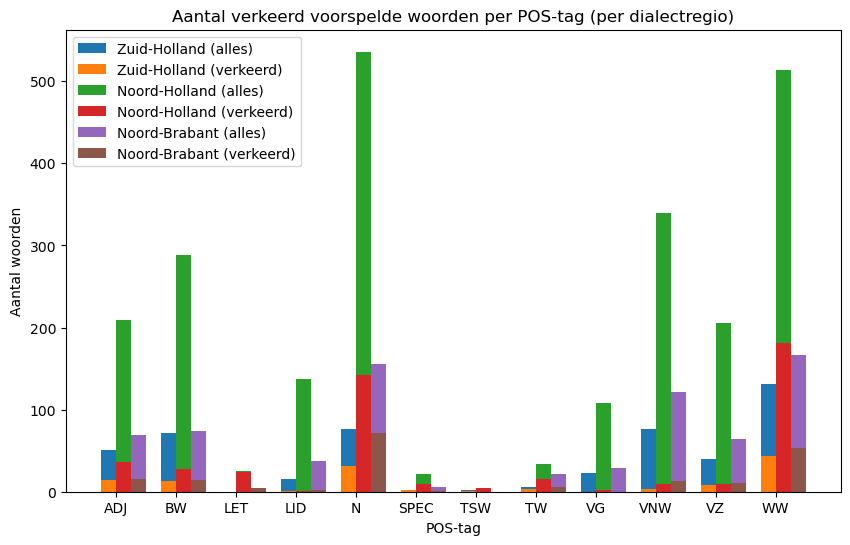

In [155]:
grouped_alles = woorden_alles.groupby(['dialectregio_y', 'POS-tag']).size().reset_index(name='Count_alles')
grouped_verkeerd = woorden.groupby(['dialectregio_y', 'POS-tag']).size().reset_index(name='Count_verkeerd')

sorted_grouped_alles = grouped_alles.sort_values(by='Count_alles', ascending=False)
sorted_grouped_verkeerd = grouped_verkeerd.sort_values(by='Count_verkeerd', ascending=False)

pivot_table_alles = sorted_grouped_alles.pivot(index='POS-tag', columns='dialectregio_y', values='Count_alles')
pivot_table_verkeerd = sorted_grouped_verkeerd.pivot(index='POS-tag', columns='dialectregio_y', values='Count_verkeerd')

provincienamen = {
    1.0: 'Zuid-Holland',
    2.0: 'Noord-Holland',
    3.0: 'Noord-Brabant'}

fig, ax = plt.subplots(figsize=(10, 6))

width = 0.25
positions = np.arange(len(pivot_table_verkeerd))

for i, dialectregio in enumerate(pivot_table_verkeerd.columns):
    provincienaam = provincienamen[dialectregio]
    ax.bar(positions + i * width, pivot_table_alles[dialectregio], width=width, label=f'{provincienaam} (alles)')
    ax.bar(positions + i * width, pivot_table_verkeerd[dialectregio], width=width, label=f'{provincienaam} (verkeerd)')

plt.xlabel('POS-tag')
plt.ylabel('Aantal woorden')
plt.title('Aantal verkeerd voorspelde woorden per POS-tag (per dialectregio)')
plt.xticks(positions + width/2, pivot_table_verkeerd.index)
plt.legend(loc = 'upper left')
plt.show()


#### WER bepalen

In [168]:
merged_df = transcripties.merge(gegevens, how='left').dropna()
merged_df.head()

,truth,whisper,spreker_id,geslacht,leeftijdscategorie,dialectregio,studio
0,Elke dag wordt alarmnummer 1-1-2 duizenden ker...,Elke dag wordt de land nummer 1 en 2 duizenden...,1.0,F,2.0,2.0,ja
1,Hier zie je de belangrijkste meldingen van woe...,Hier zie je de belangrijkste meldingen van woe...,1.0,F,2.0,2.0,ja
2,Scooterbrand slaat over op woning in Noordwijk...,Scooter Brand slaat over op woning in Noordwij...,1.0,F,2.0,2.0,ja
3,Inbreker op heet er daad betrapt in het Braban...,"Inbreker op, heet er daad betrapt, in het Brab...",1.0,F,2.0,2.0,ja
4,Zijn compagnon is nog voortvluchtig.,Zijn compagnon is nog voortvluchtig.,1.0,F,2.0,2.0,ja


In [173]:
import jiwer
from jiwer import wer

grouped_transcripties = merged_df.groupby('dialectregio')

provincienamen = {
    1.0: 'Zuid-Holland',
    2.0: 'Noord-Holland',
    3.0: 'Noord-Brabant'}

for dialectregio, transcriptie_group in grouped_transcripties:
    transcripties_truth = transcriptie_group['truth'].tolist()
    transcripties_whisper = transcriptie_group['whisper'].tolist()

    wer = jiwer.wer(transcripties_truth, transcripties_whisper)

    print(f"WER voor dialectregio {provincienamen[dialectregio]}: {wer}")


WER voor dialectregio Zuid-Holland: 0.10225563909774436
WER voor dialectregio Noord-Holland: 0.06367292225201072
WER voor dialectregio Noord-Brabant: 0.09109518935516889


In [177]:
import jiwer
import pandas as pd

grouped_transcripties = merged_df.groupby(['dialectregio', 'geslacht'])

wer_scores = []
dialectregio_labels = []
geslacht_labels = []

for (dialectregio, geslacht), transcriptie_group in grouped_transcripties:
    transcripties_truth = transcriptie_group['truth'].tolist()
    transcripties_whisper = transcriptie_group['whisper'].tolist()

    wer = jiwer.wer(transcripties_truth, transcripties_whisper)

    wer_scores.append(wer)
    dialectregio_labels.append(dialectregio)
    geslacht_labels.append(geslacht)

data = pd.DataFrame({'WER': wer_scores, 'Dialectregio': dialectregio_labels, 'Geslacht': geslacht_labels})

for (dialectregio, geslacht), group in data.groupby(['Dialectregio', 'Geslacht']):
    wer_scores = group['WER'].tolist()
    print(f"WER voor dialectregio {provincienamen[dialectregio]} en geslacht {geslacht}:")
    for wer in wer_scores:
        print(wer)
    print()


WER-scores voor dialectregio Zuid-Holland en geslacht F:
0.09824561403508772

WER-scores voor dialectregio Zuid-Holland en geslacht M:
0.12631578947368421

WER-scores voor dialectregio Noord-Holland en geslacht F:
0.060215053763440864

WER-scores voor dialectregio Noord-Holland en geslacht M:
0.1134020618556701

WER-scores voor dialectregio Noord-Brabant en geslacht M:
0.09109518935516889



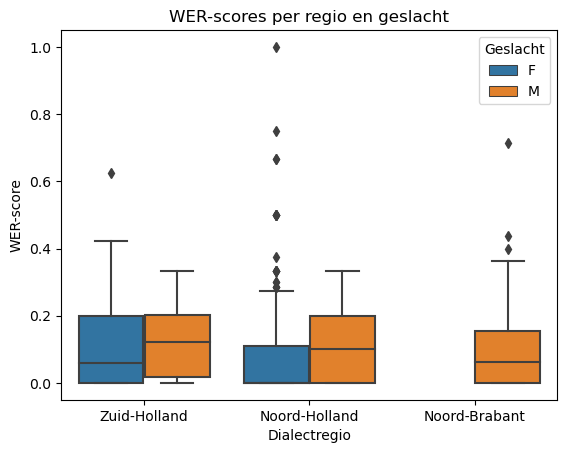

In [215]:
import jiwer
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

wer_scores = []
dialectregio = []
geslacht = []

for index, row in merged_df.iterrows():
    transcriptie_truth = row['truth']
    transcriptie_whisper = row['whisper']
    current_dialectregio = row['dialectregio']
    current_geslacht = row['geslacht']

    wer = jiwer.wer(transcriptie_truth, transcriptie_whisper)

    wer_scores.append(wer)
    dialectregio.append(current_dialectregio)
    geslacht.append(current_geslacht)

data = pd.DataFrame({'WER': wer_scores, 'Dialectregio': dialectregio, 'Geslacht': geslacht})

sns.boxplot(data=data, x='Dialectregio', y='WER', hue='Geslacht')

plt.xlabel('Dialectregio')
plt.ylabel('WER-score')
plt.title('WER-scores per regio en geslacht')
plt.xticks([0, 1, 2], ['Zuid-Holland', 'Noord-Holland', 'Noord-Brabant'])
plt.ylim(-0.05, 1.05)
plt.show()


#### Aantal transcripties: studio

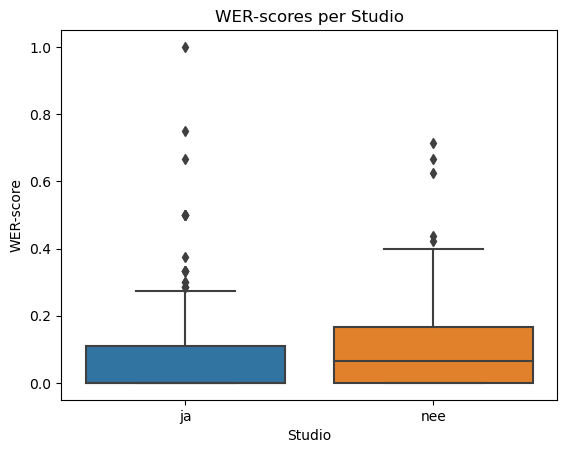

In [195]:
import jiwer
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

wer_scores = []
studio = []

for index, row in merged_df.iterrows():
    transcriptie_truth = row['truth']
    transcriptie_whisper = row['whisper']
    current_studio = row['studio']

    wer = jiwer.wer(transcriptie_truth, transcriptie_whisper)

    wer_scores.append(wer)
    studio.append(current_studio)

data = pd.DataFrame({'WER': wer_scores, 'Studio': studio})

sns.boxplot(data=data, x='Studio', y='WER')

plt.xlabel('Studio')
plt.ylabel('WER-score')
plt.title('WER-scores per Studio')
plt.ylim(-0.05, 1.05)
plt.show()


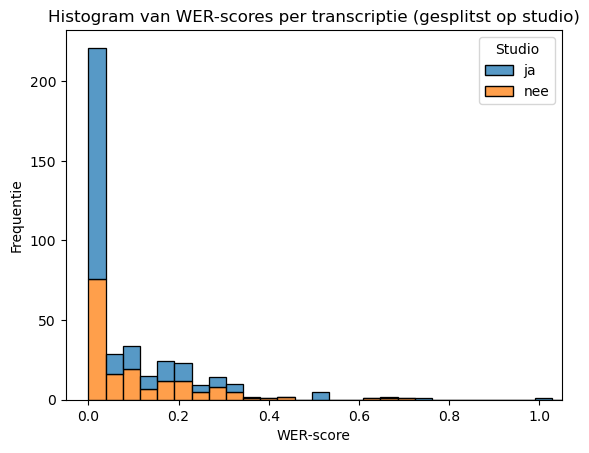

In [212]:
import jiwer
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

wer_scores = []
studio = []

for index, row in merged_df.iterrows():
    transcriptie_truth = row['truth']
    transcriptie_whisper = row['whisper']
    current_studio = row['studio']

    wer = jiwer.wer(transcriptie_truth, transcriptie_whisper)

    wer_scores.append(wer)
    studio.append(current_studio)

data = pd.DataFrame({'WER': wer_scores, 'Studio': studio})
sns.histplot(data=data, x='WER', hue='Studio', multiple='stack')

plt.xlabel('WER-score')
plt.ylabel('Frequentie')
plt.title('Histogram van WER-scores per transcriptie (gesplitst op studio)')
plt.xlim(-0.05, 1.05)
plt.show()

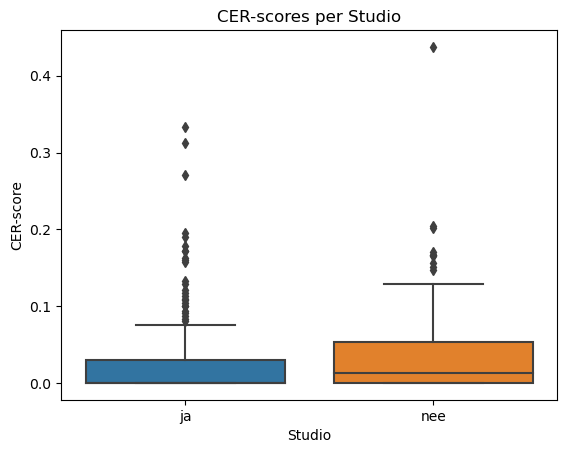

In [187]:
import editdistance
import pandas as pd

cer_scores = []
studio = []

for index, row in merged_df.iterrows():
    transcriptie_truth = row['truth']
    transcriptie_whisper = row['whisper']
    current_studio = row['studio']

    cer = editdistance.eval(transcriptie_truth, transcriptie_whisper) / len(transcriptie_truth)

    cer_scores.append(cer)
    studio.append(current_studio)

data = pd.DataFrame({'CER': cer_scores, 'Studio': studio})

sns.boxplot(data=data, x='Studio', y='CER')

plt.xlabel('Studio')
plt.ylabel('CER-score')
plt.title('CER-scores per Studio')
plt.show()


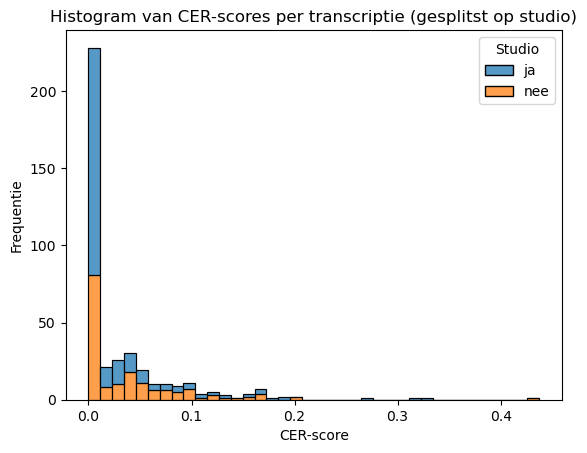

In [213]:
import jiwer
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

cer_scores = []
studio = []

for index, row in merged_df.iterrows():
    transcriptie_truth = row['truth']
    transcriptie_whisper = row['whisper']
    current_studio = row['studio']

    cer = jiwer.cer(transcriptie_truth, transcriptie_whisper)

    cer_scores.append(cer)
    studio.append(current_studio)

data = pd.DataFrame({'CER': cer_scores, 'Studio': studio})

sns.histplot(data=data, x='CER', hue='Studio', multiple='stack')

plt.xlabel('CER-score')
plt.ylabel('Frequentie')
plt.title('Histogram van CER-scores per transcriptie (gesplitst op studio)')
plt.show()